In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')
from tensorflow.python.framework import ops

C:\Users\Dwarkanath\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# 1. Load the data

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [ ]:
train.shape, test.shape

# 2. Visualize the digits

Let us look at some random digits from the training sample and their respective labels 

In [ ]:
num_images = 6
m = train.shape[0]
idx = np.random.choice(m, size=num_images)

In [ ]:
len(idx)

In [ ]:
num_rows = 2
num_cols = 3

fig, ax = plt.subplots(nrows = num_rows, ncols = num_cols)
fig.set_size_inches(12,10)

for i, j in enumerate(idx):
    # Find the right place to put the images, a is the row in the figure and b is the column
    
    a = i//num_cols
    b = i%num_cols

    # Remove ticks
    
    ax[a][b].tick_params(
    which='both',
    left=False,
    right=False,
    bottom=False,
    top=False,
    labelleft = False,
    labelbottom=False)
    
    # Draw image and set x label as the actual label of the image i.e. the value of the digit in the image
    
    ax[a][b].imshow(np.array(train.loc[j][1:]).reshape(28,28), cmap=plt.get_cmap('gray'))
    ax[a][b].set_xlabel(str(train.loc[j][0]), fontsize = 50)

plt.show()

# 3. Convert data to the right shape for CNN

Convert the flattened arrays to image arrays, normalize by dividing by 255 and separate features (X) from labels (y)

In [7]:
train.describe()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.00000,42000.000000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,...,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0
mean,4.456643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00300,0.011190,0.005143,0.000214,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000381,0.001310,0.010548,0.027262,0.050905,0.066405,0.129571,...,3.772524,2.748905,1.796452,1.089905,0.563190,0.239571,0.093524,0.024833,0.000857,0.001405,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.006143,0.035833,0.082357,0.114905,0.178714,0.301452,0.413643,0.513667,0.558833,0.677857,0.60281,0.489238,0.340214,0.219286,0.117095,0.059024,0.02019,0.017238,0.002857,0.0,0.0,0.0,0.0
std,2.887730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.56812,1.626927,1.053972,0.043916,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.078072,0.232634,1.131661,2.310396,3.121847,3.259128,4.992894,...,26.957829,22.879248,18.595109,14.434439,10.517823,6.469315,3.976306,1.846016,0.139556,0.287891,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.949803,2.350859,3.934280,4.543583,5.856772,7.219742,8.928286,10.004069,10.129595,11.254931,10.69603,9.480066,7.950251,6.312890,4.633819,3.274488,1.75987,1.894498,0.414264,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [8]:
X = np.array(train.iloc[:,1:])

In [9]:
X.shape

(42000, 784)

In [10]:
X = X.reshape((m,28,28,1))

In [11]:
y = np.array(train.label)

def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y]
    return Y

y = convert_to_one_hot(y,10)

In [12]:
y[0:5]

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [13]:
train.label.head()

0    1
1    0
2    1
3    4
4    0
Name: label, dtype: int64

In [14]:
# Set random seed

seed = 5
np.random.seed(seed)

# Get random training index

train_index = np.random.choice(m, round(m*0.9), replace=False)
dev_index = np.array(list(set(range(m)) - set(train_index)))

# Make training and dev

X_train = X[train_index]
X_dev = X[dev_index]

y_train = y[train_index]
y_dev = y[dev_index]

In [15]:
X_train.shape

(37800, 28, 28, 1)

In [16]:
m_test = test.shape[0]
X_test = np.array(test).reshape((m_test,28,28,1))


In [17]:
X_test.shape

(28000, 28, 28, 1)

In [18]:
X_train = X_train/255.
X_dev = X_dev/255.
X_test = X_test/255.
X_test = np.float32(X_test)

In [85]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of validation (dev) examples = " + str(X_dev.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("y_train shape: " + str(y_train.shape))
print ("X_dev shape: " + str(X_dev.shape))
print ("y_dev shape: " + str(y_dev.shape))
print ("X_test shape: " + str(X_test.shape))

number of training examples = 37800
number of validation (dev) examples = 4200
number of test examples = 28000
X_train shape: (37800, 28, 28, 1)
y_train shape: (37800, 10)
X_dev shape: (4200, 28, 28, 1)
y_dev shape: (4200, 10)
X_test shape: (28000, 28, 28, 1)


# 4. Apply LeNet 5 architecture

The LeNet architecture we will apply is as follows:

INPUT => CONV (28x28x20, f = 5, s = 1) => RELU => POOL (14x14x20, f = 2, s = 2) => CONV (14x14x50, f = 5, s = 1) => RELU => POOL (7x7x50, f = 2, s = 2) + flatten => FC (120) => RELU => FC (84) => softmax

Thus, there are 2 conv layers and 2 pooling layers. Then 2 fully connected layers with ReLU activation and the final layer with a softmax

In [20]:
# Create Placeholders

def create_placeholders(n_H0,n_W0,n_C0,n_y):
    X = tf.placeholder(dtype = tf.float32,shape = [None, n_H0, n_W0, n_C0])
    Y = tf.placeholder(dtype = tf.float32,shape = [None, n_y])
    return X, Y

In [97]:
# Initialize parameters

def initialize_parameters():
    tf.set_random_seed(1)
    initializer = tf.contrib.layers.xavier_initializer(seed = 0)
    W1 = tf.get_variable(name = 'W1', shape = [3, 3, 1, 20], initializer = initializer)
    W2 = tf.get_variable(name = 'W2', shape = [3, 3, 20, 50], initializer = initializer)
    parameters = {"W1": W1,
                  "W2": W2}
    
    return parameters

In [22]:
# Check parameters

tf.reset_default_graph()
with tf.Session() as sess_test:
    parameters = initialize_parameters()
    init = tf.global_variables_initializer()
    sess_test.run(init)
    print("W1 = " + str(parameters["W1"].eval()[1,1,0]))
    print("W2 = " + str(parameters["W2"].eval()[1,1,1]))

W1 = [ 0.09520774 -0.05380556  0.03309662  0.04791863  0.06486588  0.03718259
 -0.00422648  0.07948463  0.00076268  0.08207951 -0.02567826  0.0532523
  0.08675747 -0.02034826 -0.03964664  0.03036954  0.10021517 -0.0432146
 -0.09420823  0.08951879]
W2 = [-0.00947384  0.02185636  0.0385852  -0.02001796  0.04797187 -0.00908983
  0.04217046 -0.02340638  0.05509988 -0.0207608  -0.04480707  0.05384583
 -0.00270916  0.02282406 -0.01119939  0.05010575  0.03779863 -0.02780837
  0.04688966  0.05729162  0.01557302  0.00896839  0.01662358  0.01831814
  0.00139538 -0.0032947   0.03110936  0.02190141 -0.03846506 -0.00110132
 -0.00649812 -0.01068057  0.0015495  -0.00179306 -0.00896881 -0.00250364
 -0.03408847 -0.04155291 -0.03185459  0.03719625  0.03809753  0.04558766
 -0.03326112 -0.00592529 -0.02210005  0.0162257   0.00483616 -0.04424364
  0.02105067 -0.00498608]


In [117]:
# Build forward propagation computation graph

def forward_propagation(X, parameters):
    W1 = parameters['W1']
    W2 = parameters['W2']
 
    # CONV2D: stride of 1, padding 'SAME'
    Z1 = tf.nn.conv2d(X,W1, strides = [1,1,1,1], padding = 'SAME')
    # RELU
    A1 = tf.nn.relu(Z1)
    # MAXPOOL: window 2x2, stride 2, padding 'VALID'
    P1 = tf.nn.max_pool(A1, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'VALID')
    # CONV2D: filters W2, stride 1, padding 'SAME'
    Z2 = tf.nn.conv2d(P1,W2, strides = [1,1,1,1], padding = 'SAME')
    # RELU
    A2 = tf.nn.relu(Z2)
    # MAXPOOL: window 2x2, stride 2, padding 'VALID'
    P2 = tf.nn.max_pool(A2, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'VALID')
    # FLATTEN
    P2 = tf.contrib.layers.flatten(P2)
    # FULLY-CONNECTED 
    Z3 = tf.contrib.layers.fully_connected(P2, 120)
    # FULLY-CONNECTED 
    Z4 = tf.contrib.layers.fully_connected(Z3, 84)
    # FULLY-CONNECTED 
    Z5 = tf.contrib.layers.fully_connected(Z4, 10, activation_fn = tf.nn.softmax)
    
    return Z5

In [24]:
# Check forward propagation

tf.reset_default_graph()

with tf.Session() as sess:
    np.random.seed(1)
    X, Y = create_placeholders(28, 28, 1, 10)
    parameters = initialize_parameters()
    Z5 = forward_propagation(X, parameters)
    init = tf.global_variables_initializer()
    sess.run(init)
    a = sess.run(Z5, {X: np.random.randn(2,28,28,1), Y: np.random.randn(2,10)})
    print("Z5 = " + str(a))
    

Z5 = [[0.11024383 0.11148221 0.08968562 0.08140747 0.05738164 0.10887462
  0.10808303 0.09480074 0.11396542 0.12407539]
 [0.12073991 0.10642184 0.08286864 0.0773964  0.05666392 0.12295366
  0.11110857 0.08536462 0.11765698 0.11882541]]


In [25]:
# Compute Cost

def compute_cost(Z5, Y):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = Z5, labels = Y))
    return cost

In [26]:
# Check cost function

tf.reset_default_graph()

with tf.Session() as sess:
    np.random.seed(1)
    X, Y = create_placeholders(28, 28, 1, 10)
    parameters = initialize_parameters()
    Z5 = forward_propagation(X, parameters)
    cost = compute_cost(Z5, Y)
    init = tf.global_variables_initializer()
    sess.run(init)
    a = sess.run(cost, {X: np.random.randn(4,28,28,1), Y: np.random.randn(4,10)})
    print("cost = " + str(a))

cost = 5.043827


In [118]:
# Set hyperparameters and optimization function

learning_rate = 0.001
num_epochs = 10
batch_size = 32


In [31]:
def model(X_train, X_test, X_dev, y_train, y_dev, learning_rate = learning_rate, num_epochs = num_epochs, batch_size = batch_size, print_cost = True):
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    (m_train, n_H0, n_W0, n_C0) = X_train.shape             
    n_y = y_train.shape[1]                            
    costs = []                                        # To keep track of the cost
    num_batches = (m_train//batch_size) + 1
    
    # Create Placeholders of the correct shape
    
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)
    

    # Initialize parameters
    
    parameters = initialize_parameters()
    
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    
    Z5 = forward_propagation(X, parameters)
    
    
    # Cost function: Add cost function to tensorflow graph
    
    cost = compute_cost(Z5, Y)
    
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer that minimizes the cost.
    
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
    
    
    # Initialize all the variables globally
    init = tf.global_variables_initializer()
  

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:

        # Run the initialization
        sess.run(init)

        for epoch in range(num_epochs):
            # Generate random batch index
            minibatch_cost = 0
            full_batch = range(m_train)

            for batch in range(num_batches):        
                try:
                    batch_index = np.random.choice(full_batch, size=batch_size, replace = False)
                    full_batch = np.array(list(set(full_batch) - set(batch_index)))
                except ValueError:
                    batch_index = full_batch
                batch_train_X = X_train[batch_index]
                batch_train_y = y_train[batch_index]

                # Run session to reach goal 

                sess.run(optimizer, feed_dict={X: batch_train_X, Y: batch_train_y})
                temp_cost = sess.run(cost, feed_dict={X: batch_train_X, Y: batch_train_y})
                minibatch_cost += temp_cost / num_batches

            # Print the cost every epoch
            
            print ("Cost after epoch %i: %f" % (epoch+1, minibatch_cost))
            costs.append(minibatch_cost)


        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # Calculate the correct predictions
        predict_op = tf.argmax(Z5, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
      
        # Calculate accuracy on the train and dev sets
        
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print(accuracy)
        train_accuracy = accuracy.eval({X: X_train, Y: y_train})
        dev_accuracy = accuracy.eval({X: X_dev, Y: y_dev})
        print("Train Accuracy:", train_accuracy)
        print("Dev Accuracy:", dev_accuracy)
        
        # Make predictions
        train_preds = sess.run(predict_op, feed_dict ={X:X_train})
        test_preds = sess.run(predict_op, feed_dict ={X:X_test})
        
        return train_accuracy, dev_accuracy, parameters, train_preds, test_preds

Cost after epoch 1: 1.596768
Cost after epoch 2: 1.486441
Cost after epoch 3: 1.478408
Cost after epoch 4: 1.476820
Cost after epoch 5: 1.474294
Cost after epoch 6: 1.472907
Cost after epoch 7: 1.471918
Cost after epoch 8: 1.471253
Cost after epoch 9: 1.470640
Cost after epoch 10: 1.470674


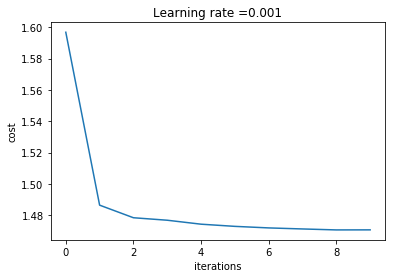

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 0.99269843
Dev Accuracy: 0.98714286


In [119]:
train_accuracy, dev_accuracy, parameters, train_preds, test_preds = model(X_train, X_test, X_dev, y_train, y_dev, learning_rate = learning_rate, num_epochs = num_epochs, batch_size = batch_size, print_cost = True)

# 5. Check random sample prediction from test set

Test sample no.: 12922
Prediction: 3


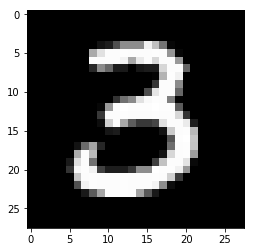

In [120]:
i = np.random.choice(m_test)
print("Test sample no.: {}".format(i))

print('Prediction: {}'.format(test_preds[i]))
plt.imshow(X_test[i,:,:,0],cmap = plt.get_cmap('gray'))
plt.show()


# 6. Check which ones are incorrect from the training set

In [121]:
train_labels = np.argmax(y_train, axis = 1)

In [122]:
train_new = pd.DataFrame()

In [123]:
train_new['Label'] = train_labels
train_new['Preds'] = train_preds
m_train = X_train.shape[0]
train_new['ImageId'] = list(range(m_train))

In [124]:
train_new.head()

,Label,Preds,ImageId
0,3,3,0
1,5,5,1
2,1,1,2
3,4,4,3
4,0,0,4


In [125]:
train_mismatch = train_new[train_new['Label']!=train_new['Preds']]

In [126]:
train_mismatch.Label.value_counts()

9    66
7    41
3    36
5    32
8    29
2    20
6    17
0    14
4    13
1     8
Name: Label, dtype: int64

Image ID.: 17747
Prediction: 2
Correct Label: 7


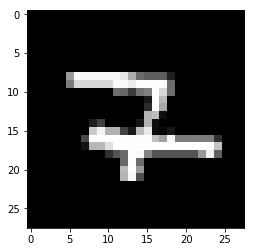

In [128]:
i = np.random.choice(train_mismatch['ImageId'])
print("Image ID.: {}".format(i))
print('Prediction: {}'.format(train_preds[i]))
print('Correct Label: {}'.format(train_labels[i]))
plt.imshow(X_train[i,:,:,0],cmap = plt.get_cmap('gray'))
plt.show()

# 7. Write submission file

In [113]:
test['Label'] = test_preds

In [114]:
test['ImageId'] = list(range(1,m_test+1))

In [115]:
test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,Label,ImageId
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,3
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,5


In [116]:
test[['ImageId', 'Label']].to_csv('submission_lenet5.csv', index = False, header = ['ImageId','Label'])